### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [4]:
import os
path = os.getcwd()

if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb #UiB paths
else:
    %run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb # Mac paths

All MAC paths are set!


In [5]:
%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%matplotlib inline

#%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
#pd.set_option('display.float_format', '{:.6E}'.format)
#pd.reset_option("all")

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


/Users/andreas/miniforge3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
187 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 287 flags
Removed 287 flags from df
df sorted by tus
2019-02-06 03:49:28.525262
first tus:  -707119.0833333334 | max tus:  1302732.5833333333
24300
tus array OK ...


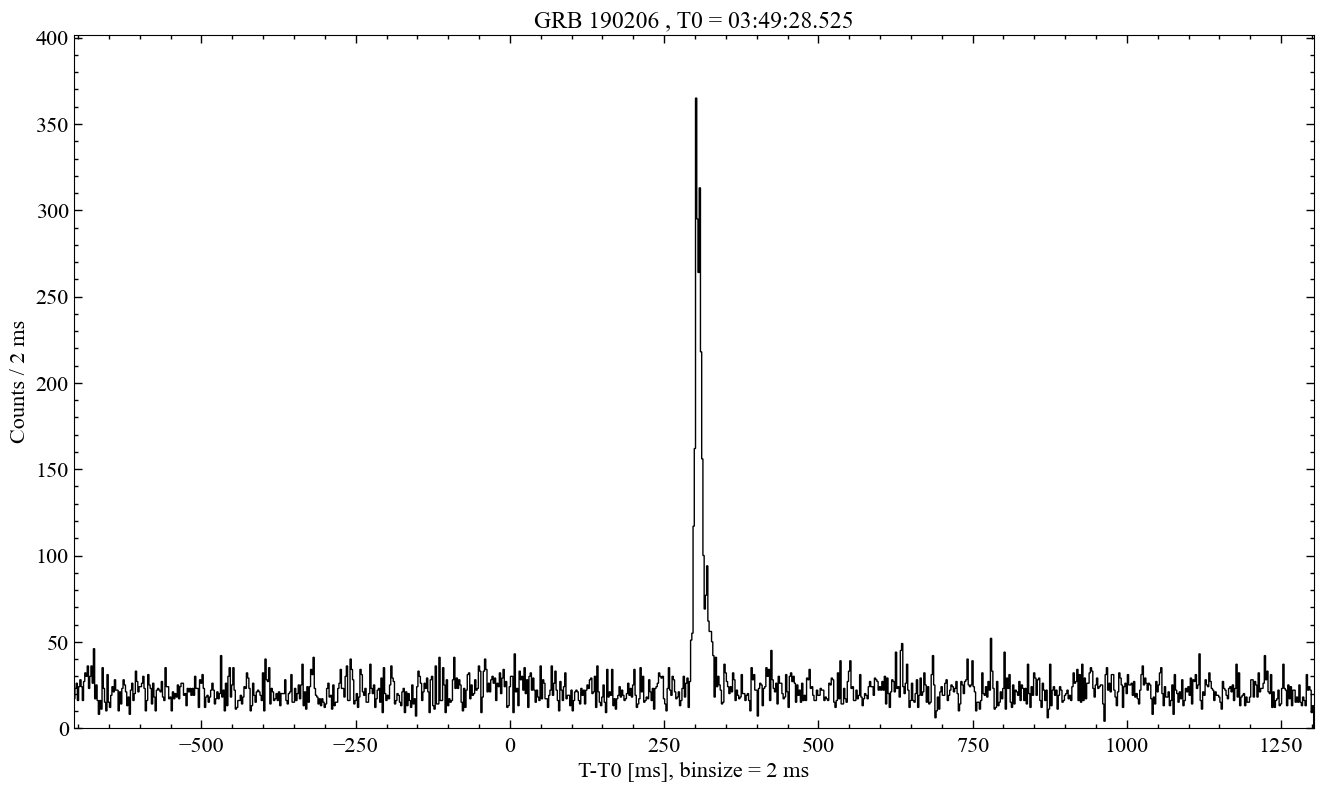

In [6]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB190206",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

## KW prep

bin start:  -0.512 bin end 0.512


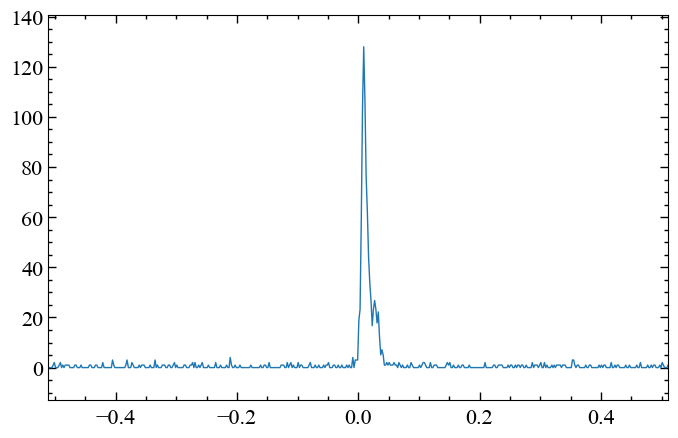

In [7]:
kw_filename = "GRB190206A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002
ToF = 0.7142


kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print("bin start: ", kw_bin_lo[0], "bin end",kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kwLC = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kwLC.plot()

kw_lc.plot(labels=["T-T0 [s]","counts/2ms"],title="GRB 201227A KW 360-1360 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorralation/KW_originalLC.png")

# CrossCorr
    TODO:
        -Make a function for finding the optimal tlagg
        -run the laggs array containing all of the possible tlaggs.
        -Time range (+- T s) selected from peak count rate pr bin

### ASIM prep

In [8]:
laggApprox = 28.525-4.9225-23.926
print(np.round(laggApprox,3))

-0.323


asimBkg:  9.33235294117647


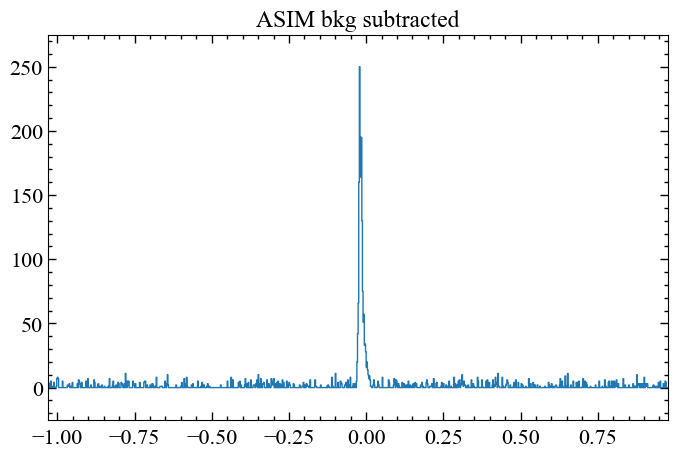

In [9]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 399<=kev<=1633: #399-1633
        indexInBound.append(i)
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]  
tus += laggApprox
#asim_binsOrg = np.round(np.arange(-1.5,2,binsize,dtype=np.float32),3)
asim_binsOrg = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
hist = np.histogram(tus,bins=asim_binsOrg)
asimCounts,asimEdges = hist[0],hist[1]

iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
iAsimBkgEnd = find_nearest(asimEdges,-0.25)
asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM bkg subtracted")
plt.show()


#df = pd.DataFrame(data={"Ti":np.round(asimEdges[:-1],3), "Tf":np.round(asimEdges[1:],3), "Counts":np.round(asimCounts,2)})
#np.savetxt(fname="asimLC_tshift_-0.531s",X=df,fmt=["%.3f","%.3f","%.2f"],header="Ti,Tf,Counts",delimiter=",")
#asimLC = LC(time=np.round(asimEdges[:-1],3)+binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)

## Comparing LC's with approx tshift

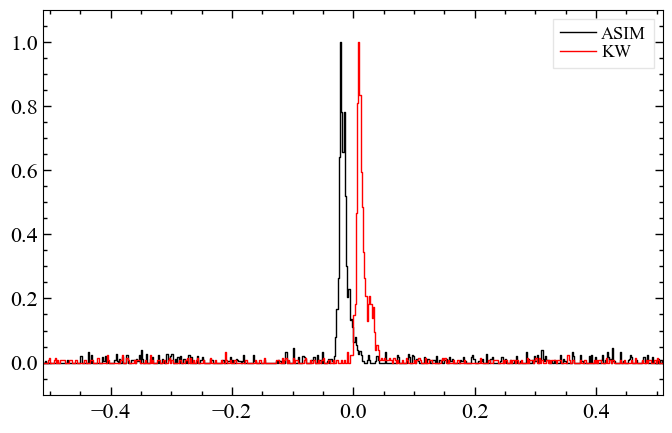

In [10]:
iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
iAsimEnd = find_nearest(asimEdges,kw_bin_lo[-1])


plt.step(x=asimEdges[iAsimStart:iAsimEnd],y=asimCounts[iAsimStart:iAsimEnd]/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red")
plt.legend()
plt.show()
#Good tlaggApprox, but ASIM needs to be shifted in + direction ~+0.03s

### building asimLC

In [11]:
asimLC = LC(time=asimEdges[iAsimStart:iAsimEnd]+binsize/2,counts=asimCounts[iAsimStart:iAsimEnd],dt=0.002,skip_checks=True)

asimLC.plot(labels=["T-T0 [s] ASIM ref. frame","counts/2ms"],title="GRB 201227A, ASIM 360-1360 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorralation/ASIM_originalLC.png")

## CC algo

Total lagg (s):  -0.2934999999999992 | CC lagg:  0.03


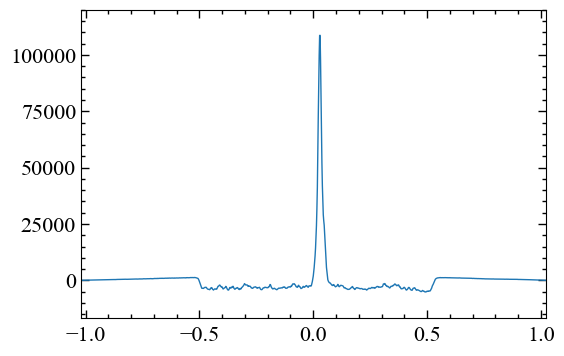

<AxesSubplot: >

In [12]:
CC = CrossCorrelation(kwLC,asimLC,mode="full")
CClagg=CC.time_shift
tlagg = laggApprox + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
CC.plot()

# Building final LC's

asimBkg:  9.323076923076924


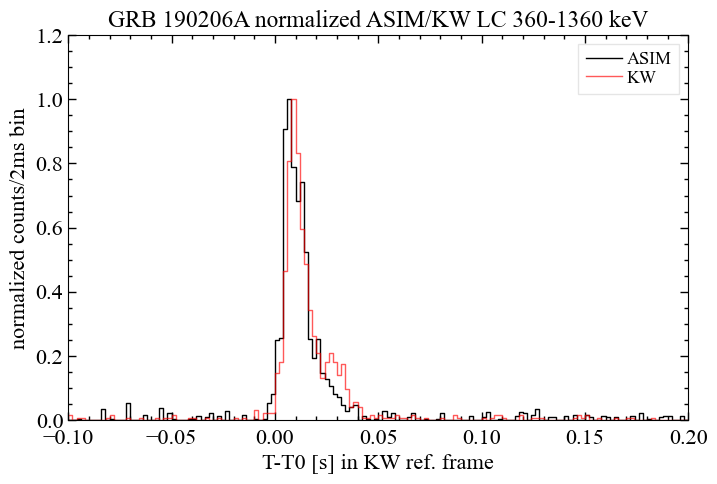

In [15]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 399<=kev<=1633:
        indexInBound.append(i)
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]  
tus += -0.296 #tlagg
#asim_binsOrg = np.round(np.arange(-1.5,2,binsize,dtype=np.float32),3)
asim_binsOrg = np.round(np.arange(-1,1+binsize,binsize),3)
hist = np.histogram(tus,bins=asim_binsOrg)
asimCounts,asimEdges = hist[0],hist[1]

iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
iAsimBkgEnd = find_nearest(asimEdges,-0.25)
asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
iAsimEnd = find_nearest(asimEdges,kw_bin_hi[-1])

plt.step(x=asimEdges[iAsimStart:iAsimEnd],y=asimCounts[iAsimStart:iAsimEnd]/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)

plt.title("GRB 190206A normalized ASIM/KW LC 360-1360 keV")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("normalized counts/2ms bin")
#plt.vlines(x=0.0,ymin=0,ymax=1.1,color="g",label="T0: {}".format(T0_KW.isoformat(timespec="milliseconds")),alpha=0.6,linestyle="--")
plt.legend()
plt.xlim(left=-0.1,right=0.2)
plt.ylim(bottom=0,top=1.2)
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/overlappingLC_asim_kw.png")
plt.legend()
plt.show()
#Good tlaggApprox, but ASIM needs to be shifted in + direction ~+0.03s

### Approx shift

In [16]:
T0_approx = T0_ASIM+timedelta(seconds=laggApprox)
T0_KW = datetime.strptime("2020-12-27 15:14:06.705","%Y-%m-%d %H:%M:%S.%f")

plt.plot(np.round(asimCompare.bin_lo,3),asimCompare.counts/max(asimCompare),label="ASIM shifted by {} s, \n 360-1360 keV".format(laggApprox))
plt.plot(np.round(kwCompare.bin_lo,3),kwCompare.counts/max(kwCompare),c="r",alpha=0.6,label="KW 360-1360 keV")

plt.title("GRB 201227A normalized ASIM/KW light curve")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("counts/2ms bin")
plt.vlines(x=0.0,ymin=-0.1,ymax=1.1,color="g",label="T0: {} ".format(T0_KW.isoformat(timespec='milliseconds')),alpha=0.6,linestyle="--")
plt.legend()
plt.ylim(bottom=0,top=1.2)
plt.xlim(left=-0.2,right=max(kwCompare.bin_lo))
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/ASIM_KW_AppShift.png")
plt.show()

NameError: name 'asimCompare' is not defined

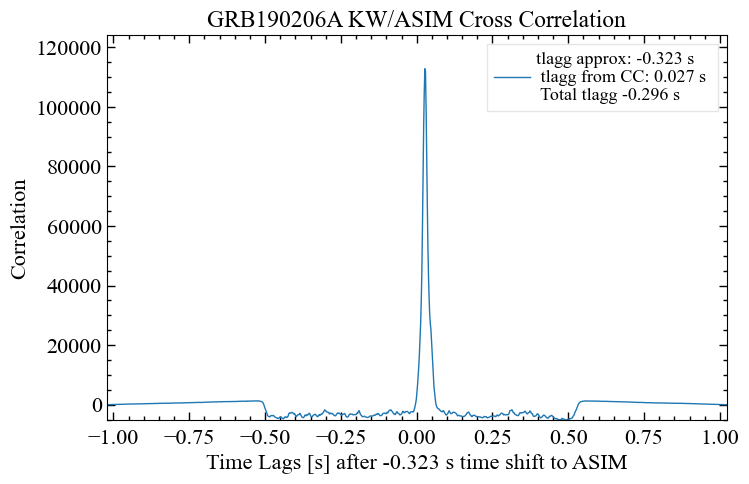

In [72]:
plt.plot(CC.time_lags,CC.corr,label="tlagg approx: {} s \n tlagg from CC: {} s \n Total tlagg {} s".format(np.round(laggApprox,3), np.round(CClagg,3), np.round(tlagg,3)))
plt.title("GRB190206A KW/ASIM Cross Correlation")
plt.xlabel('Time Lags [s] after {} s time shift to ASIM'.format(np.round(laggApprox,3)))
plt.ylabel('Correlation')
plt.legend()
plt.ylim(bottom=min(CC.corr),top=max(CC.corr)+max(CC.corr)/1e1)
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/CC_asim_kw.png")
plt.show()

# Extracting ASIM data

In [6]:
tlagg = -0.296 # [s] from newest calibration

In [7]:
ASIM_df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
187 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 287 flags
Removed 287 flags from df
df sorted by tus


tus array OK ...


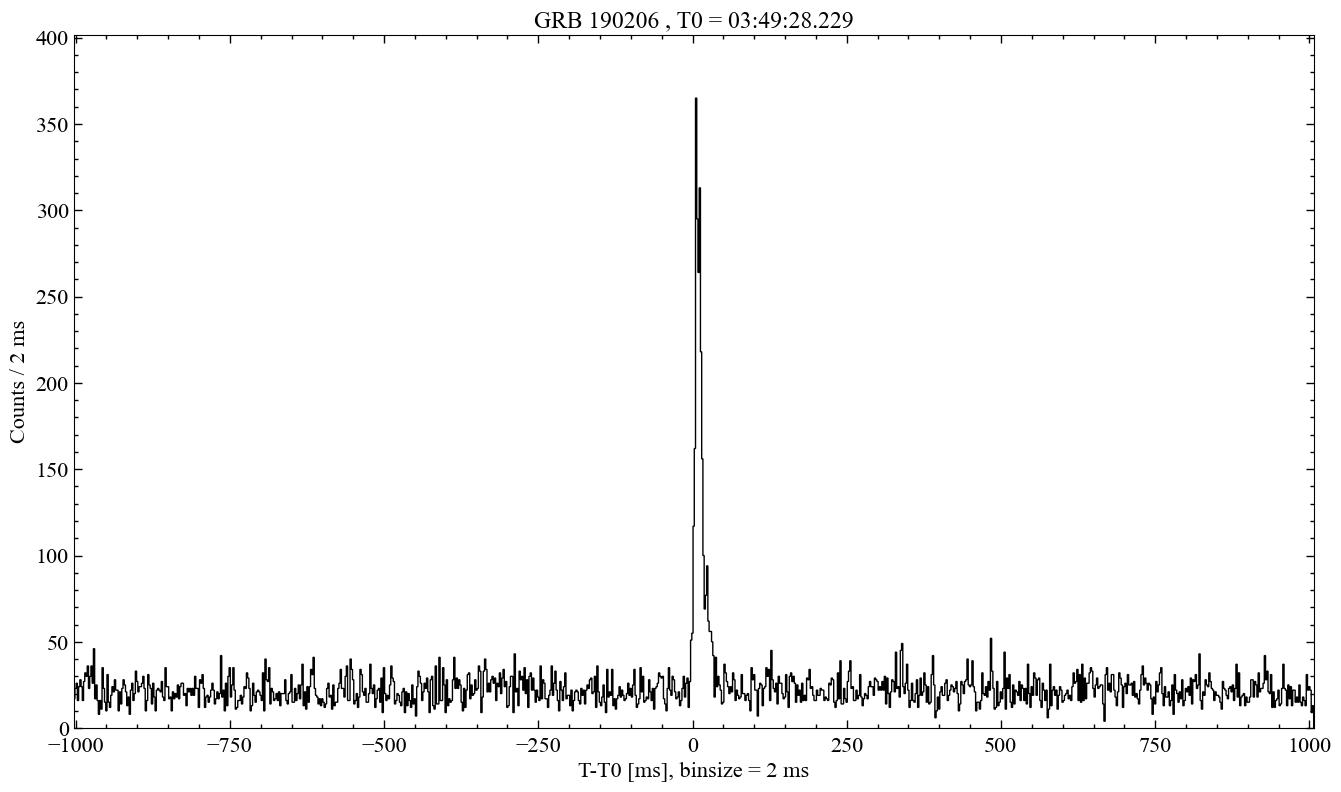

In [8]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=2)

In [9]:
keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max"
                 )
keV_df.head(n=15)
#All triggers in the time_interval are kept

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  2889
n triggers are within bounds  2889
keV bins are set for HED
Energies binned!


,bins_keV,counts,poisson_error_counts
0,10.00000,0,0.000000
1,12.58925,0,0.000000
2,15.84893,0,0.000000
3,19.95262,0,0.000000
4,25.11886,0,0.000000
5,31.62278,0,0.000000
6,39.81072,0,0.000000
7,50.11872,0,0.000000
8,63.09573,0,0.000000
9,79.43282,0,0.000000


### bakground extraction 

In [18]:
keV_bg = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.1),
                 keV_interval="max")
keV_bg.head(n=15)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  8664
n triggers are within bounds  8664
keV bins are set for HED
Energies binned!


,bins_keV,counts,poisson_error_counts
0,10.00000,0,0.0
1,12.58925,0,0.0
2,15.84893,0,0.0
3,19.95262,0,0.0
4,25.11886,0,0.0
5,31.62278,0,0.0
6,39.81072,0,0.0
7,50.11872,0,0.0
8,63.09573,0,0.0
9,79.43282,0,0.0


# Exporting fits files

In [11]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb

### PHA

In [57]:
T0_shift.isoformat()
313.330, -30.510 #ra,dec

'2019-02-06T03:49:28.229262'

In [12]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-02-06T03:49:28.230','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.064,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190206A','Name of the observed object'], #<str> 
    'RA_OBJ': [313.330,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-30.510,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB190206.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB190206.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB190206.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's


In [15]:
bin_lo = keV_df['bins_keV'].to_numpy()[:-1]
bin_hi = keV_df['bins_keV'].to_numpy()[1:]
counts = keV_df['counts'].to_numpy()[1:]
err = keV_df['poisson_error_counts'].to_numpy()[1:]

In [16]:
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [17]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK

In [19]:
bak_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2019-02-06T03:49:28.230','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [-0.9,'[s] Start time of background spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [-0.1,'End time of background spectrum accumulation'], #<float> [s]
'EXPOSURE': [0.6,'[s] Integration time in seconds for the BAK data'], #<float> 
'OBJECT': ['GRB190206A','Name of the observed object'], #<str> 
'RA_OBJ': [313.330,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-30.510,'[deg] Dec of source'], #<float>
'FILENAME': ['HED_GRB190206.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [20]:
bak_counts = keV_bg['counts'].to_numpy()[1:]
bak_err = keV_bg['poisson_error_counts'].to_numpy()[1:]

In [21]:
generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP

In [22]:
rsp_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2019-02-06T03:49:28.230','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
'EXPOSURE': [0.064,'[s] Integration time in seconds for the PHA data'], #<float> 
'OBJECT': ['GRB190206A','Name of the observed object'], #<str> 
'RA_OBJ': [313.330,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-30.510,'[deg] Dec of source'], #<float>
'FILENAME': ['HED_GRB190206.rsp','RSP filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [23]:
110.882, -36.976 #theta, phi angles for the incomming radiation reaching the ISS
drmfname = 'HED_drm_mats_105.00_30.00.txt'

In [24]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi)